# Falling Carbon Intensity

This notebook focuses on estimating the long-term trend for the UP power network's carbon intensity

<br>

### Imports

In [1]:
## Data Manipulation
import pandas as pd
import numpy as np

## Plotting
from statsmodels.graphics.gofplots import qqplot
import matplotlib.pyplot as plt
import seaborn as sns

## Stats
from statsmodels.nonparametric.smoothers_lowess import lowess 
from sklearn.base import BaseEstimator, RegressorMixin

from scipy.stats import norm
from scipy.stats import anderson
from scipy.stats import normaltest
from scipy.stats import shapiro

## Jupyter Extensions
from ipypb import track

<br>

### Helper Functions

In [2]:
def hide_spines(ax, positions=['top', 'right']):
    """
    Pass a matplotlib axis and list of positions with spines to be removed
    
    args:
        ax:          Matplotlib axis object
        positions:   Python list e.g. ['top', 'bottom']
    """
    assert isinstance(positions, list), 'Position must be passed as a list '
    
    for position in positions:
        ax.spines[position].set_visible(False)

def form_intvl_idx(s):
    """
    This function accepts a (sorted) pandas series and returns the same series 
    where the standard index has been replaced with an interval index.
    """
    
    s = s.drop_duplicates()
    
    left_side = pd.Series(s.index).shift(1).fillna(-np.inf).values
    right_side = pd.Series(s.index).values
    right_side[-1] = np.inf

    int_idx = pd.IntervalIndex.from_arrays(left_side, right_side)
    s.index = int_idx
    
    s = s.bfill().ffill()
        
    return s

class sklearn_loess(BaseEstimator, RegressorMixin):
    def __init__(self, lowess, kwargs={'frac':0.3, 'it':3}):
        self.lowess = lowess
        self.kwargs = kwargs
        self.loess_fit = None
        self.loess_map = None
 
    def fit(self, X, y):
        self.loess_fit = self.lowess(y, X, **self.kwargs)
        
        index, data = np.transpose(self.loess_fit)
        s_loess = pd.Series(data, index=index)
        
        self.loess_map = form_intvl_idx(s_loess)
 
    def predict(self, X):
        prediction = np.array([self.loess_map[x] for x in X])
        
        return prediction

<br>

### Reading in Data

In [3]:
%%time

df_EI = pd.read_csv('data/EI.csv')

df_EI.index = pd.to_datetime(df_EI['local_datetime'], utc=True)
df_EI = df_EI.drop(columns='local_datetime')

df_EI.head()

Wall time: 3.3 s


,day_ahead_price,SP,imbalance_price,valueSum,temperature,TCO2_per_h,gCO2_per_kWh,nuclear,biomass,coal,...,demand,pumped_storage,windOnshore,windOffshore,belgian,dutch,french,ireland,northern_ireland,irish
local_datetime,,,,,,,,,,,,,,,,,,,,,
2009-01-01 00:00:00+00:00,58.05,1,74.74,74.74,-0.6,21278.0,555.0,6.973,0.0,17.650,...,38.329,-0.404,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.161
2009-01-01 00:30:00+00:00,56.33,2,74.89,74.89,-0.6,21442.0,558.0,6.968,0.0,17.770,...,38.461,-0.527,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:00:00+00:00,52.98,3,76.41,76.41,-0.6,21614.0,569.0,6.970,0.0,18.070,...,37.986,-1.018,NaN,NaN,0.0,0.0,1.977,0.0,0.0,-0.160
2009-01-01 01:30:00+00:00,50.39,4,37.73,37.73,-0.6,21320.0,578.0,6.969,0.0,18.022,...,36.864,-1.269,NaN,NaN,0.0,0.0,1.746,0.0,0.0,-0.160
2009-01-01 02:00:00+00:00,48.70,5,59.00,59.00,-0.6,21160.0,585.0,6.960,0.0,17.998,...,36.180,-1.566,NaN,NaN,0.0,0.0,1.730,0.0,0.0,-0.160


<br>

### Visualising the Data

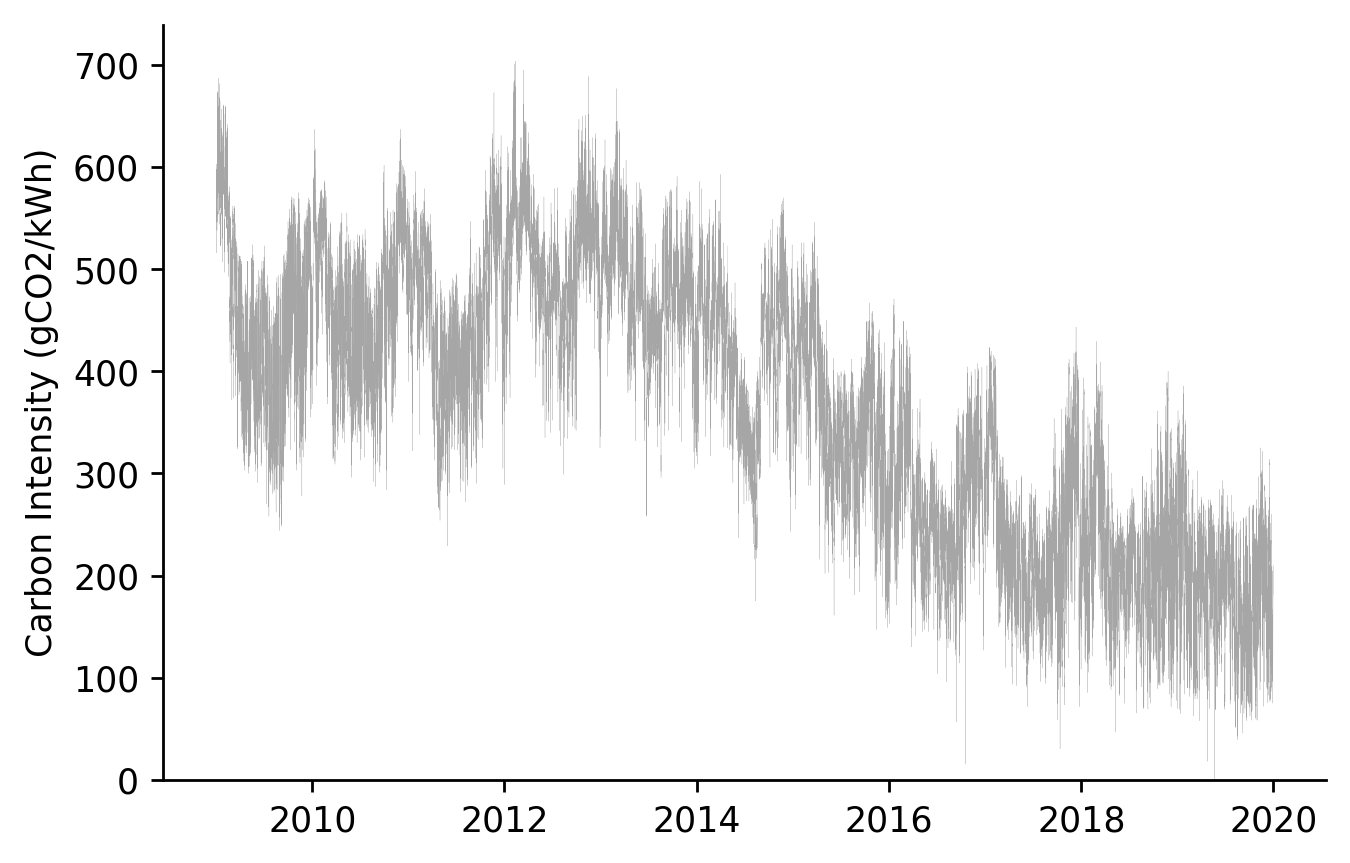

In [29]:
def plot_co2(s_CI, label=None, alpha=0.35, zorder=0):
    fig, ax = plt.subplots(dpi=250)

    ax.plot(s_CI.index, s_CI.values, color='k', alpha=alpha, linewidth=0.075, zorder=zorder, label=label)

    hide_spines(ax)
    ax.set_ylim(0)
    ax.set_xlabel('')
    ax.set_ylabel('Carbon Intensity (gCO2/kWh)')
    
    return fig, ax

s_CI = df_EI['gCO2_per_kWh']

fig, ax = plot_co2(s_CI)

<br>

### Fitting LOESS Model

We start by taking a subset of the data in order to speed up the calculations

In [5]:
s_CI_sample = s_CI.sample(5000).sort_index()

X = s_CI_sample.index.values.astype(float)
y = s_CI_sample.values

y

array([549.        , 581.        , 584.        , ..., 126.77945323,
       159.43892135, 197.63020336])

<br>

We're now ready to fit the LOESS curve and use it to make predictions

In [6]:
%%time

loess_kwargs = {
    'frac' : 0.3,
    'it' : 3
}
skl_loess = sklearn_loess(lowess, loess_kwargs)

skl_loess.fit(X, y)
loess_pred = skl_loess.predict(X)

loess_pred

Wall time: 3.41 s


array([461.68897261, 461.68533561, 461.68333141, ..., 178.61000147,
       178.59760661, 178.52819071])

<br>

The LOESS fit can also be shown alongside the original values

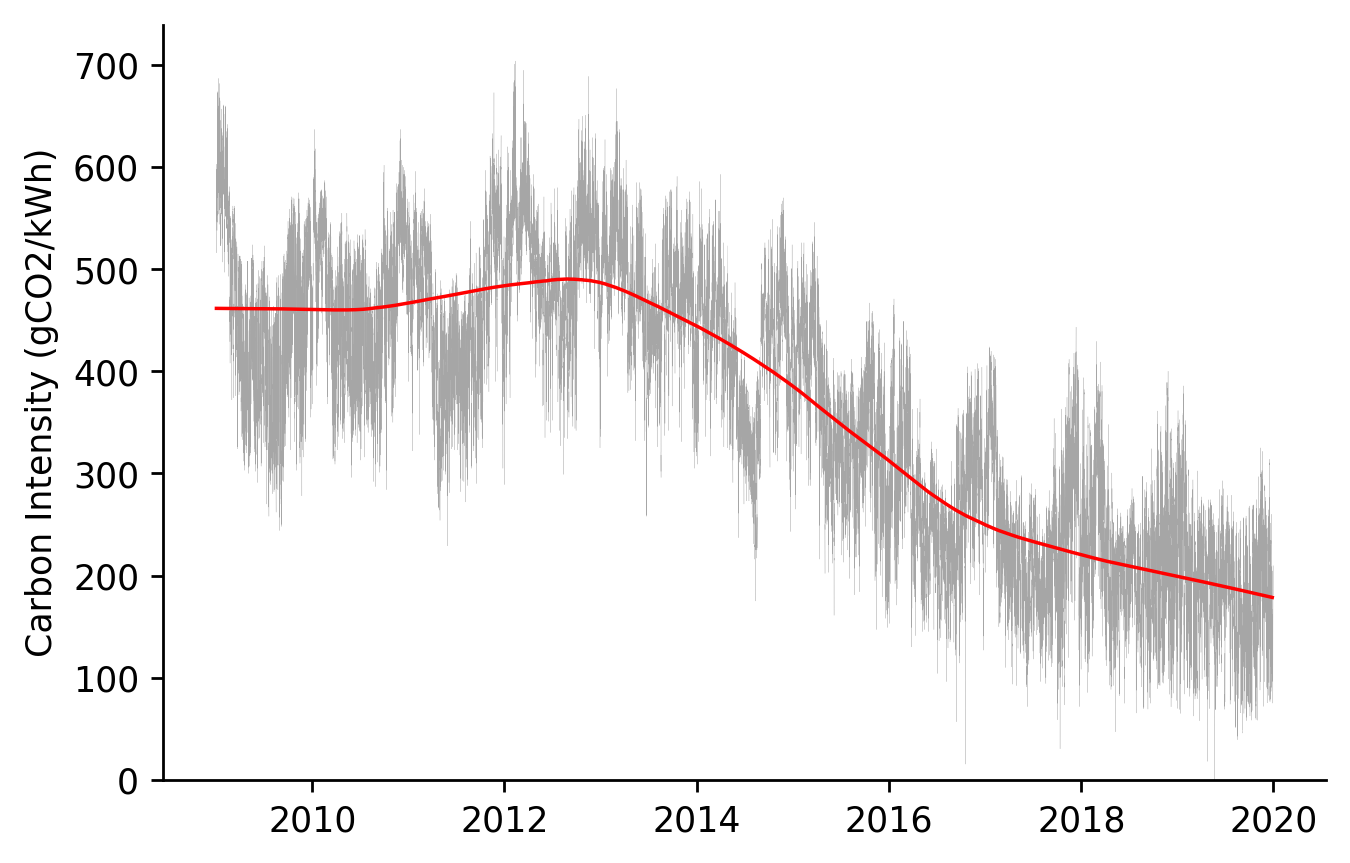

In [7]:
fig, ax = plot_co2(s_CI)

ax.plot(pd.to_datetime(X), loess_pred, color='red', linewidth=1, linestyle='-')

<br>

Out of interest we'll also calculate the fall in carbon intensity for the long term trend between January 2010 and December 2019

In [8]:
X_2010_jan = s_CI['2010-01'].index.values.astype(float)
X_2019_dec = s_CI['2019-12'].index.values.astype(float)

avg_CI_2010_jan = skl_loess.predict(X_2010_jan).mean()
avg_CI_2019_dec = skl_loess.predict(X_2019_dec).mean()

pct_change = (avg_CI_2019_dec - avg_CI_2010_jan)/avg_CI_2010_jan

print(f'{pct_change:.1%}')

-61.1%


<br>

### Bootstrapping Long-Term Trend

For this particular model we'll use bootstrapping in two applications:

* Determining the uncertainty around the LOESS mean estimate
* Determining the uncertainty around the estimate of the standard deviation

We'll start by creating a wrapper which generates the bootstrap sample as well as a set of 'out of bag' test samples

In [9]:
%%time

def bootstrap_vals(s, n_samples=50000):
    s_boot = s.sample(n=n_samples, replace=True).sort_index()
    oob_list = list(set(list(s.items())) - set(list(s_boot.items())))

    index = pd.DatetimeIndex([x[0] for x in oob_list])
    values = [x[1] for x in oob_list]

    s_oob = pd.Series(values, index=index).sort_index()
    
    return s_boot, s_oob

s_boot, s_oob = bootstrap_vals(s_CI)

s_boot

Wall time: 1.91 s


local_datetime
2009-01-01 01:00:00+00:00    569.000000
2009-01-01 03:30:00+00:00    592.000000
2009-01-01 06:30:00+00:00    574.000000
2009-01-01 07:00:00+00:00    562.000000
2009-01-01 07:30:00+00:00    546.000000
                                ...    
2019-12-30 16:30:00+00:00    182.644428
2019-12-30 17:00:00+00:00    188.674561
2019-12-30 18:00:00+00:00    187.283827
2019-12-30 18:30:00+00:00    187.639308
2019-12-30 19:00:00+00:00    197.138414
Name: gCO2_per_kWh, Length: 50000, dtype: float64

<br>

We need to now create several of these bootstrap and out of bag sample sets 

In [10]:
%%time

def boot_n_oob_2_pred(s_boot, s_oob, X_test=False):
    X_train = s_boot.index.values.astype(float)
    y_train = s_boot.values
    
    if isinstance(X_test, bool):
        X_test = s_oob.index.values.astype(float)
    
    skl_loess = sklearn_loess(lowess, loess_kwargs)
    skl_loess.fit(X_train, y_train)
    
    y_pred = skl_loess.predict(X_test)
    
    return y_pred

num_sets = 100

oob_sets = []
boot_sets = []
y_preds = []
    
s_test = s_CI.sample(10000).sort_index()
X_test = s_test.index.values.astype(float)

for i in track(range(num_sets)):
    s_CI_subset = (s_CI
                   .drop(s_test.index)
                   .sample(10000)
                  )
    
    s_boot, s_oob = bootstrap_vals(s_CI_subset, n_samples=5000)    
    y_pred = boot_n_oob_2_pred(s_boot, s_oob, X_test=X_test)
    
    boot_sets += [s_boot]
    oob_sets += [s_oob]
    y_preds += [y_pred]

 [████████████████████████████████████████████████████████████] 100/100 [07:42<00:03, 4.62s/it]

Wall time: 7min 41s


<br>

We can now determine confidence limit quantiles for the LOESS estimates, in this example we'll take the 95% confidence range

Wall time: 1.02 s


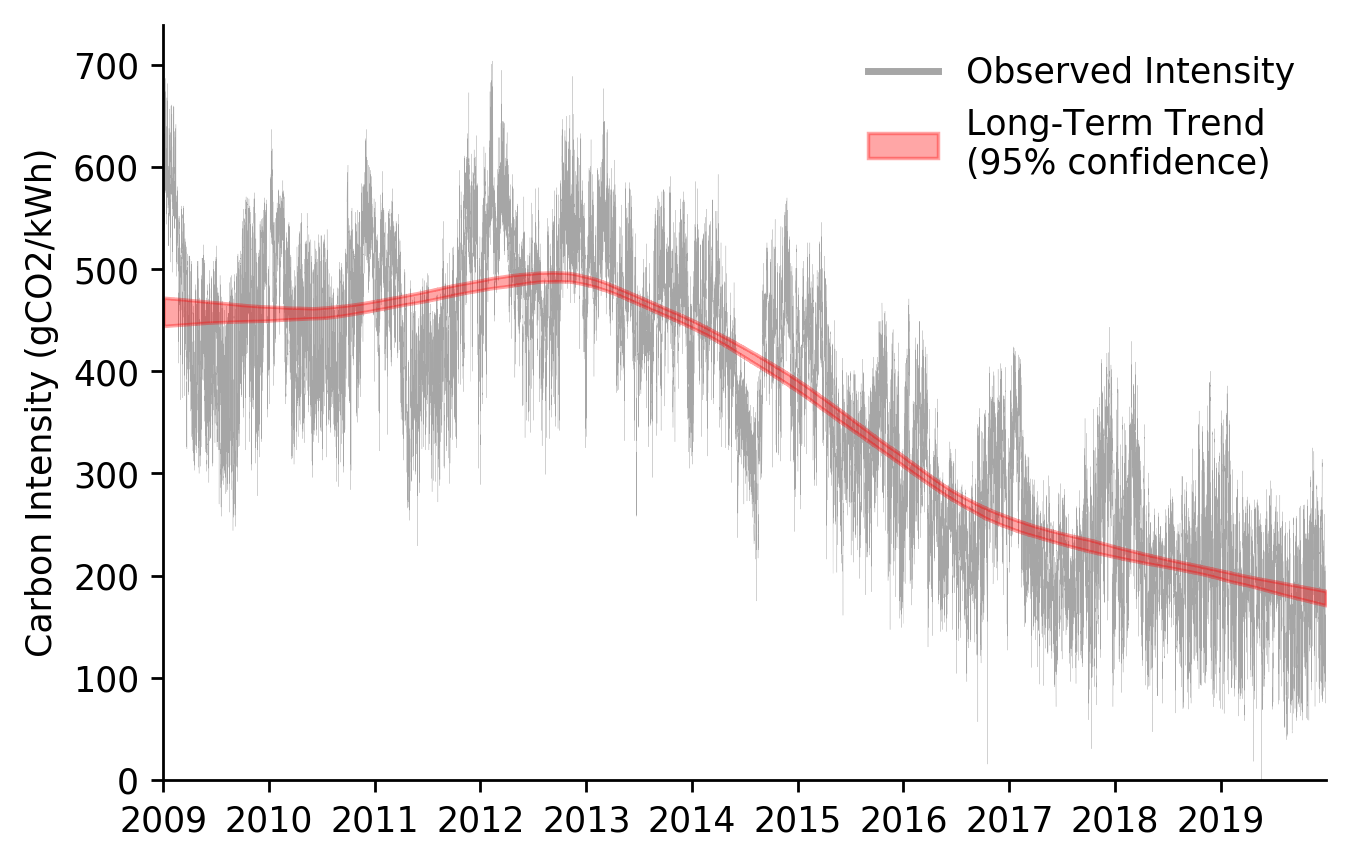

In [15]:
%%time

q_conf = 0.95

q_max = round(q_conf + (1-q_conf)/2, 5)
q_min = round(1 - q_max, 5)

df_preds = pd.DataFrame(y_preds).T.dropna(how='all')
df_preds.index = pd.to_datetime(X_test)

top_quant = df_preds.quantile(q_max, axis=1)
bottom_quant = df_preds.quantile(q_min, axis=1)

## Plotting
fig, ax = plot_co2(s_CI, label='Observed Intensity')

ax.fill_between(top_quant.index, top_quant.values, bottom_quant.values, 
                color='red', zorder=1, alpha=0.35, label='Long-Term Trend\n(95% confidence)')

ax.set_xlim(s_CI.index[0], s_CI.index[-1])

leg = ax.legend(frameon=False, loc=1)
for line in leg.get_lines():
    line.set_linewidth(2)
    
#fig.savefig('img/falling_carbon_intensity.png')

<br>

### Determining Residual Distribution

We start by fitting a LOESS curve and calculating the residuals

In [16]:
%%time

## Fitting LOESS curve
s_boot, s_oob = bootstrap_vals(s_CI.sample(15000), n_samples=7500)    
y_pred = boot_n_oob_2_pred(s_boot, s_oob)

## Calculating residuals
pred_errs = (s_oob - y_pred).dropna()
norm_pred_errs = (pred_errs-pred_errs.mean())/pred_errs.std()

pred_errs.head()

Wall time: 5.69 s


2009-01-01 04:30:00+00:00    142.679990
2009-01-01 05:00:00+00:00    135.679990
2009-01-01 17:30:00+00:00     98.675223
2009-01-01 18:00:00+00:00    103.675223
2009-01-02 13:30:00+00:00    127.671006
dtype: float64

<br>

We then fit those residuals to a normal distribution

[]

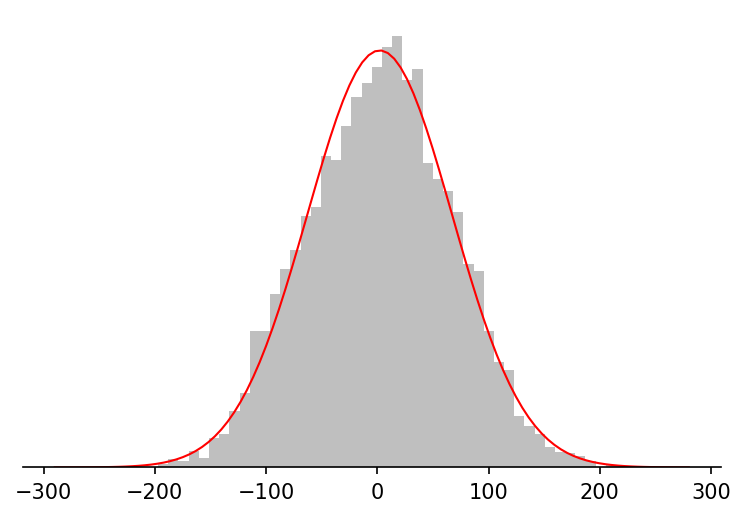

In [17]:
mu, std = norm.fit(pred_errs)

xmax = round(pred_errs.max()*1.25, -1)
xmin = round(pred_errs.min()*1.25, -1)

x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

## Plotting
fig, ax = plt.subplots(dpi=150)

ax.plot(x, p, color='red', linewidth=1)
sns.distplot(pred_errs, ax=ax, kde=False, norm_hist=True, color='k', hist_kws={'alpha':0.25})

hide_spines(ax, positions=['top', 'left', 'right'])
ax.set_yticks([])

<br>

They appear to follow a normal distribution, we can inspect how close it is visually through a QQ plot

Text(0, 0.5, 'Residual Error')

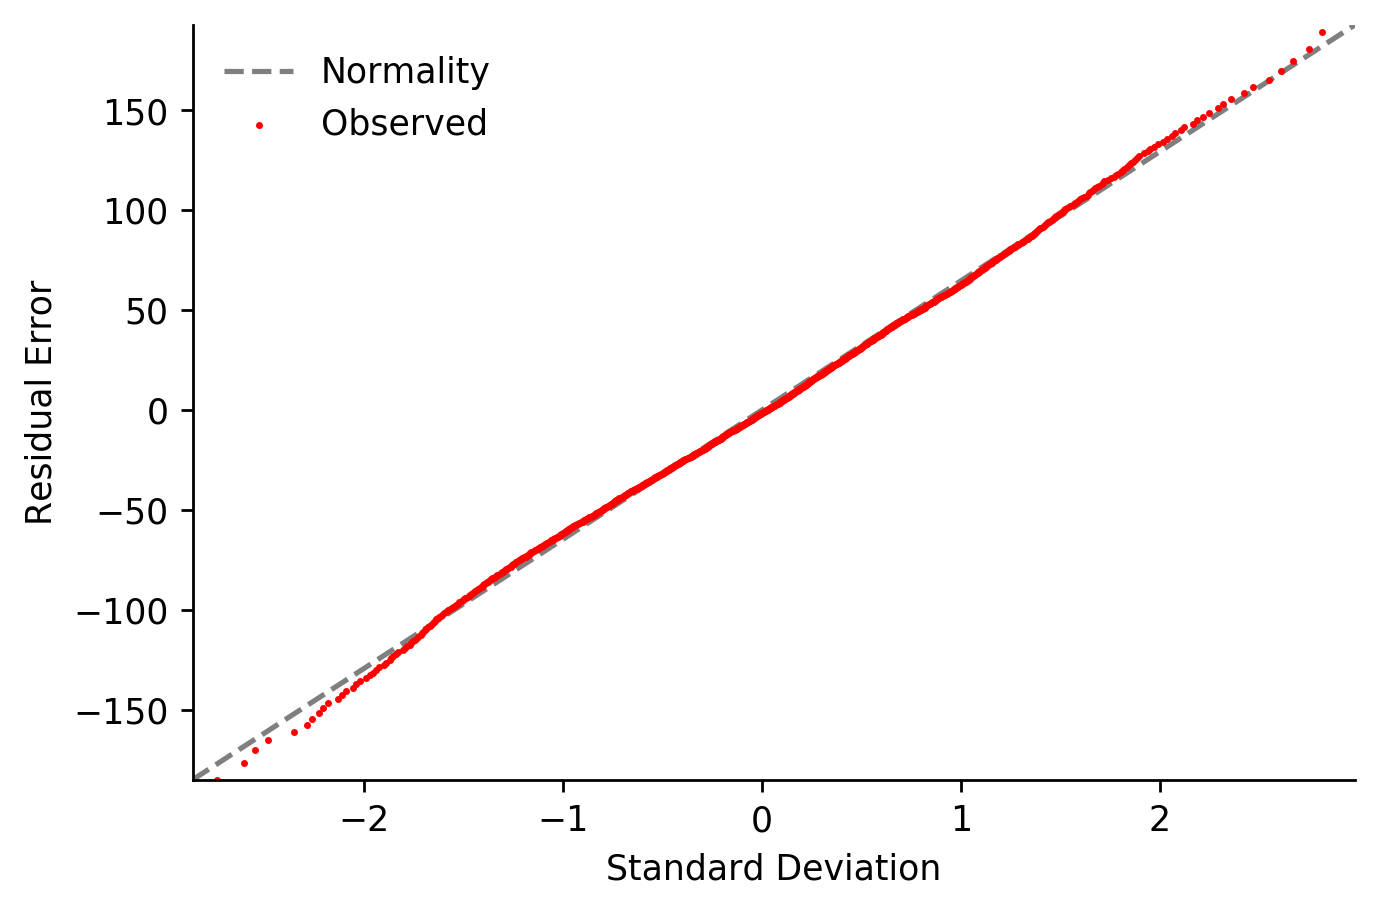

In [18]:
q_pred = pred_errs.quantile(np.linspace(0.001, 0.999, num=999))
q_pred_norm = norm.ppf(q_pred.index, mu, std)

q_pred_std_devs = q_pred/q_pred.std()

## Plotting
fig, ax = plt.subplots(dpi=250)

ax.plot(q_pred_std_devs, q_pred, zorder=0, color='k', linestyle='--', alpha=0.5, label='Normality')
ax.scatter(q_pred_std_devs, q_pred_norm, zorder=1, s=1, color='red', label='Observed')

hide_spines(ax)
ax.legend(frameon=False)
ax.set_xlim(q_pred_std_devs.min(), q_pred_std_devs.max())
ax.set_ylim(q_pred.min(), q_pred.max())
ax.set_xlabel('Standard Deviation')
ax.set_ylabel('Residual Error')

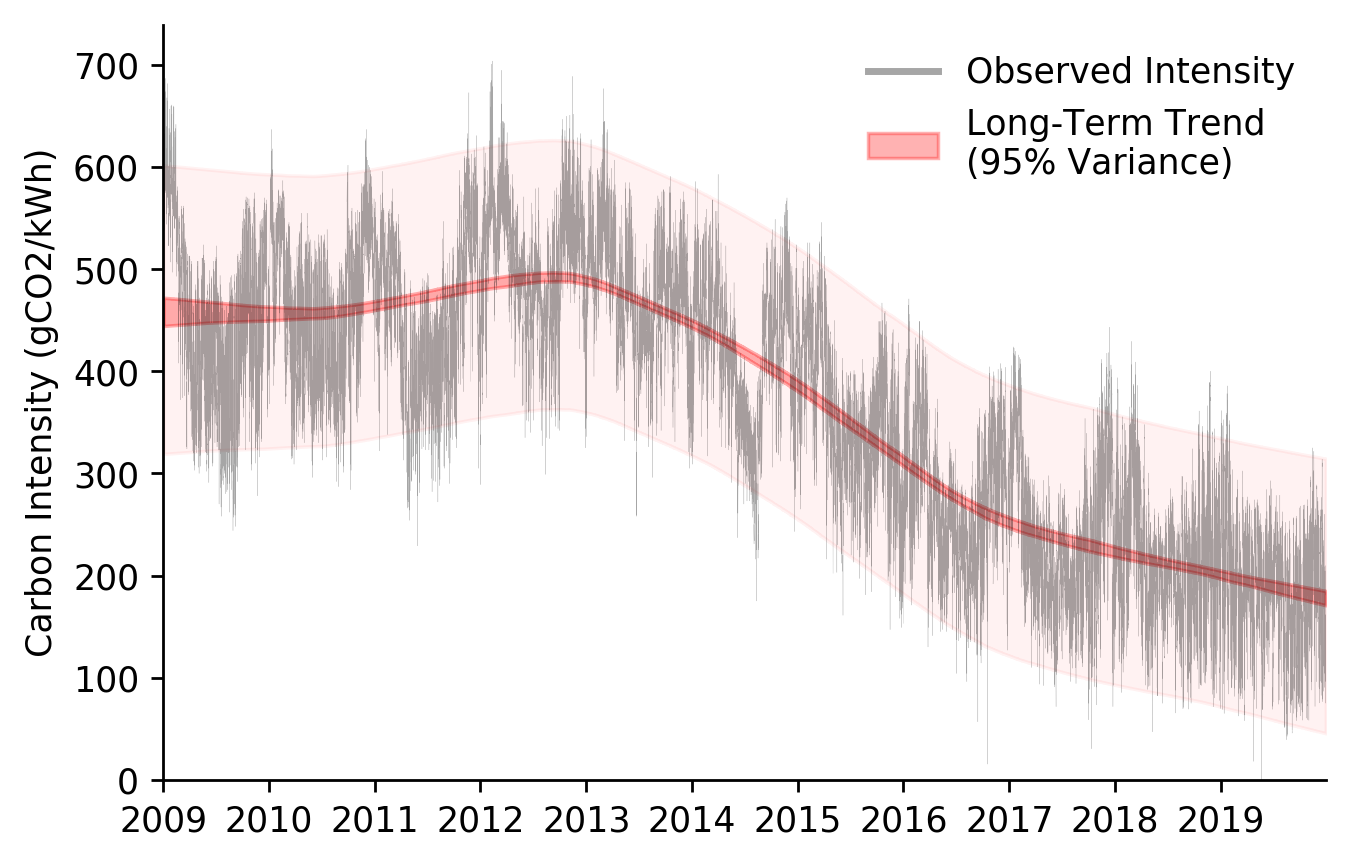

In [42]:
ci95_min = bottom_quant + norm.ppf(0.025, mu, std)
ci95_max = top_quant + norm.ppf(0.975, mu, std)

## Plotting
fig, ax = plot_co2(s_CI, label='Observed Intensity', zorder=2)

ax.fill_between(ci95_max.index, ci95_max.values, ci95_min.values, 
                color='red', zorder=0, alpha=0.05, label=None)
ax.fill_between(top_quant.index, top_quant.values, bottom_quant.values, 
                color='red', zorder=1, alpha=0.3, label='Long-Term Trend\n(95% Variance)')

ax.set_xlim(s_CI.index[0], s_CI.index[-1])

leg = ax.legend(frameon=False, loc=1)
for line in leg.get_lines():
    line.set_linewidth(2)